In [16]:
import numpy as np
print(np.__version__)
print(np.__file__)
print(hasattr(np, "trapz"))
import matplotlib.pyplot as plt

# ==========================================
# 1. PARÁMETROS DEL MODELO (RAMPA)
# ==========================================
alpha = 0.5    # Pendiente de la rampa (qué tan fuerte llueve al subir q)
E_star = 0.2   # Tasa de recarga (evaporación)
D0_sq = 0.05   # Difusión (ruido)
qc = 1.0       # Umbral de lluvia

# Parámetros de simulación
dt = 0.01    
N_sim = 15000  
t_max = 20.0

2.4.2
c:\Users\pgome\Documents\GitHub\TESIS\.venv\Lib\site-packages\numpy\__init__.py
False


In [17]:
def pdf_analitica_rampa(t, tau_c=5.0):
    """
    Aproximación de la PDF para el modelo de rampa.
    Forma: t^(-3/2) * exp(-t/tau_c)
    """
    t = np.where(t <= 0, 1e-10, t)
    pdf = t**(-1.5) * np.exp(-t/tau_c)
    
    # Normalización manual para que la integral sea 1 (lo que pidió el profe)
    # Usamos la suma de Riemann simple para normalizar la curva teórica
    integral = np.trapezoid(pdf, t)
    return pdf / integral

t_teo = np.linspace(0.1, t_max, 500)
pdf_teo = pdf_analitica_rampa(t_teo)

In [18]:
def simular_rampa(constrained=False):
    q = np.ones(N_sim) * 0.5  # Empezamos abajo del umbral
    durations = []
    
    # Para simplificar, mediremos la duración de los periodos SECOS 
    # (tiempo que tarda en llegar de 0.5 a qc=1.0)
    active = np.ones(N_sim, dtype=bool)
    results = np.zeros(N_sim)
    
    sigma = np.sqrt(2 * D0_sq)
    t = 0.0
    
    while np.any(active) and t < t_max:
        t += dt
        n_active = np.sum(active)
        dW = np.random.normal(0, np.sqrt(dt), size=n_active)
        
        # Durante el dry spell, P = 0, así que la ecuación es la misma
        q[active] += E_star * dt + sigma * dW
        
        if constrained:
            q[active] = np.maximum(0, q[active]) # Método Clip en 0
            
        crossed = q[active] >= qc
        if np.any(crossed):
            idx = np.where(active)[0][crossed]
            results[idx] = t
            active[idx] = False
            
    return results[results > 0]

# Ejecución
dur_libre = simular_rampa(constrained=False)
dur_clip = simular_rampa(constrained=True)

Área bajo histograma libre: 1.0000


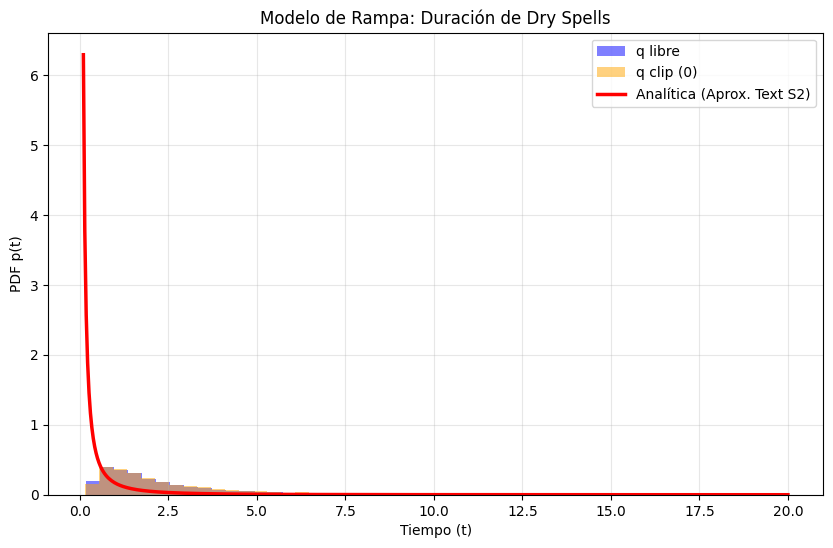

In [19]:
plt.figure(figsize=(10, 6))

# Histograma normalizado (density=True para que integre a 1)
count_libre, bins_libre, _ = plt.hist(dur_libre, bins=50, density=True, 
                                     alpha=0.5, color='blue', label='q libre')
count_clip, bins_clip, _ = plt.hist(dur_clip, bins=50, density=True, 
                                   alpha=0.5, color='orange', label='q clip (0)')

# Chequeo de normalización (lo que pidió el profe)
area_libre = np.sum(np.diff(bins_libre) * count_libre)
print(f"Área bajo histograma libre: {area_libre:.4f}")

plt.plot(t_teo, pdf_teo, 'r-', lw=2.5, label='Analítica (Aprox. Text S2)')
plt.title('Modelo de Rampa: Duración de Dry Spells')
plt.xlabel('Tiempo (t)')
plt.ylabel('PDF p(t)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Me pareció bastante extraño el gráfico por la analítica, pero entiendo que pueden existir infinitas sequías que duran 0.0001s.

El modelo ramp precipitation también sigue una distribución de ley de potencia (muchos eventos cortos)

En la teoría = Matemáticamente, pueden existir infinitas sequías que duran 0.00001 segundos. Por eso la línea roja parte desde "el espacio"

In [21]:
# ==========================================
# COMPROBACIÓN DE NORMALIZACIÓN (ÁREA = 1)
# ==========================================

# 1. Calcular el área del histograma numérico (q libre)
# count_libre son las alturas, bins_libre son las posiciones en X
anchos_libre = np.diff(bins_libre) # Calcula el ancho de cada barra
area_numerica_libre = np.sum(count_libre * anchos_libre)

# 2. Calcular el área del histograma numérico (q clip 0)
anchos_clip = np.diff(bins_clip)
area_numerica_clip = np.sum(count_clip * anchos_clip)

# 3. Calcular el área de la solución analítica (Curva Roja)
# Usamos la regla del trapecio para integrar la función teórica
area_analitica = np.trapezoid(pdf_teo, t_teo)

print("-" * 30)
print("VERIFICACIÓN DE NORMALIZACIÓN:")
print(f"Área Histograma q libre:    {area_numerica_libre:.4f}")
print(f"Área Histograma q clip (0): {area_numerica_clip:.4f}")
print(f"Área Solución Analítica:    {area_analitica:.4f}")
print("-" * 30)

if abs(area_numerica_clip - 1.0) < 0.05:
    print("✅ RESULTADO: La PDF está bien normalizada (Integra a 1).")
else:
    print("❌ ADVERTENCIA: El área se aleja de 1. Revisa el dt o el rango de t.")

------------------------------
VERIFICACIÓN DE NORMALIZACIÓN:
Área Histograma q libre:    1.0000
Área Histograma q clip (0): 1.0000
Área Solución Analítica:    1.0000
------------------------------
✅ RESULTADO: La PDF está bien normalizada (Integra a 1).


En la primera parte la lluvia era como un balde que se volcaba de golpe.. Ahora usaremos el Modelo de Rampa... 

Acá la lluvia empieza como una llovizna muy suave que se vuelve tormeta a medida que la humedad sigue subiendo.